# Домашнее задание 3

Выполнил Козин Роман

# Часть 1. Классификатор 128×128

## Датасет

Для ускорения процесса обучения используем не весь датасет ImageNet, возьмём часть классов. Пусть будет 20 классов. Выберем их случайным образом

In [45]:
import matplotlib.pyplot as plt
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
import numpy as np
import random
import torch

In [46]:
random.seed(52)
torch.manual_seed(52)
np.random.seed(52)

In [47]:
CLASS_NUM = 20
classes_path = './data/tiny-imagenet-200/tiny-imagenet-200/wnids.txt'
with open(classes_path) as f:
    ids = f.read().split('\n')
selected_classes = random.sample(ids[:-1], CLASS_NUM)
print(selected_classes)

['n01882714', 'n02279972', 'n02699494', 'n02123394', 'n03026506', 'n01910747', 'n04532106', 'n07920052', 'n02058221', 'n07695742', 'n02268443', 'n07753592', 'n03160309', 'n04356056', 'n01784675', 'n02124075', 'n04417672', 'n02927161', 'n04540053', 'n09193705']


На всякий случай зафиксируем

In [48]:
selected_classes = ['n01882714', 'n02279972', 'n02699494', 'n02123394', 'n03026506', 
                    'n01910747', 'n04532106', 'n07920052', 'n02058221', 'n07695742', 
                    'n02268443', 'n07753592', 'n03160309', 'n04356056', 'n01784675', 
                    'n02124075', 'n04417672', 'n02927161', 'n04540053', 'n09193705']

Возьмём ту же реализацию датасета из прошлого ДЗ, останется только добавить resize в изображения. Делать дополнительной стратификации для разделения датасета на обучение и валидацию не нужно, в ImageNet датасет уже разбит на нужные выборки.

In [49]:
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torch.nn as nn
from tqdm import tqdm
from PIL import Image
import torch
import os

class SmallDataset(Dataset):
    def __init__(self, root: str, classes: list[str], ds_type: str, device = torch.device("cpu"), transform = None) -> None:
        super().__init__()
        self.ds_type = ds_type
        self.root = root
        self.classes = classes
        if ds_type == 'val':
            self.prepareValData()
        self.device = device
        self.transform = transform
        self.label_to_idx = {label : idx for idx, label in enumerate(classes)}
        
    def prepareValData(self) -> None:
        self.valData = []
        labelsSet = set(self.classes)
        with open(os.path.join(self.root, self.ds_type, "val_annotations.txt")) as f:
            rows = f.readlines()
            f.close()    
        for row in rows:
            data = self._parseLine(row)
            label = data[1]
            if label in labelsSet:
                self.valData.append(tuple(data))
    
    def _parseLine(self, row: str):
        els = row.split("\t")
        data = [els[k].strip("\n") for k in range(len(els))]
        if self.ds_type == 'val':
            start_idx = 2
        else:
            start_idx = 1
        for i in range(start_idx, len(data)):
            data[i] = int(data[i])
        return data
    
    def __getitem__(self, index: int):
        if self.ds_type == 'val':
            data = self.valData[index]
            img_path = os.path.join(self.root, self.ds_type, "images", data[0])
            label = data[1]
            bbox = tuple(data[2:])
        else:
            label_idx = index // 500
            img_idx = index % 500
            label = self.classes[label_idx]
            label_root = os.path.join(self.root, self.ds_type, label)
            img_path = os.path.join(label_root, "images", f'{label}_{img_idx}.JPEG')
            with open(os.path.join(label_root, f"{label}_boxes.txt")) as f:
                rows = f.readlines()
                f.close()
            row = rows[img_idx]
            data = self._parseLine(row)
            bbox = tuple(data[1:])
        
        bbox = torch.tensor(bbox).to(self.device)
        img = Image.open(img_path).convert('RGB')
            
        if self.transform:
            img = self.transform(img)
        return (img.to(self.device), torch.tensor(self.label_to_idx[label]).to(self.device), bbox)
        
    def __len__(self) -> int:
        #структура исходного датасета такова, что на каждый класс приходится 500 изображений
        if self.ds_type == 'train':
            return len(self.classes) * 500
        else:
            return len(self.valData)

Увеличим размер изображений до 128x128 при помощи ```transforms.Resize()```, используем стандартную билинейную интерполяцию. Также в тренировку добавим несколько аугментаций для более стабильного обучения. Добавим аугментации, предложенные в задании: RandomResizedCrop, Flip, Rotation.

В RandomResizedCrop выставим адекватные размеры обрезки, чтобы не оставлять в датасете слишком маленькие участки исходного изображения.

В RandomRotation используем повороты до 30 градусов, чтобы тоже слишком сильно не искажать изображения.

In [50]:
train_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((128, 128)),
    transforms.RandomResizedCrop((128, 128), (0.9, 1)),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(30),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], #найденные в интернете параметры для imagenet
                        std=[0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((128, 128)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], #найденные в интернете параметры для imagenet
                        std=[0.229, 0.224, 0.225])
])

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
data_root = "./data/tiny-imagenet-200/tiny-imagenet-200"
train_data = SmallDataset(root=data_root, classes=selected_classes,
                          ds_type='train', transform=train_transforms, device=device)
val_data = SmallDataset(root=data_root, classes=selected_classes,
                        ds_type='val', transform=val_transforms, device=device)
train_data_loader = DataLoader(train_data,batch_size=16, shuffle=True)
val_data_loader = DataLoader(val_data, batch_size=16, shuffle=True)

In [7]:
img, label, bbox = train_data[0]

print(img.shape)

torch.Size([3, 128, 128])


## Модель

Сперва ради эксперимента попробуем обучить модель из прошлого дз и посмотрим на её точность. Используем тот же код для обучения, также будем использовать AdamW.

In [5]:
from copy import deepcopy

def train_one_run(model, optimizer, criterion, train_data_loader, val_data_loader, save_path, epoch_num=20):
    train_acc_history = []
    val_acc_history = []
    train_loss_history = []
    val_loss_history = []

    best_val_acc = 0.0
    best_state_dict = None
    train_acc = None

    for epoch in range(epoch_num):
        train_correct = 0
        train_predicted = 0
        model.train()
        
        for images, labels, _ in tqdm(desc=f"Training epoch {epoch + 1}", iterable=train_data_loader):
            optimizer.zero_grad()
            logits = model(images)
            loss = criterion(logits, labels)
            loss.backward()
            optimizer.step()
            
            preds = logits.argmax(dim=-1)
            train_correct += (preds == labels).sum().item()
            train_predicted += labels.size(0)
        
        train_loss_history.append(loss.item())
        train_acc_history.append(train_correct / train_predicted)

        model.eval()
        val_correct = 0
        val_predicted = 0
        
        with torch.no_grad():
            for images, labels, _ in tqdm(iterable=val_data_loader, desc=f"Validating"):
                logits = model(images)
                loss = criterion(logits, labels)
                preds = logits.argmax(dim=-1)
                val_correct += (preds == labels).sum().item()
                val_predicted += labels.size(0)
            
            val_loss_history.append(loss.item())
            val_acc = val_correct / val_predicted
            val_acc_history.append(val_acc)

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_state_dict = deepcopy(model.state_dict())
            train_acc = train_correct / train_predicted
            torch.save(model.state_dict(), save_path)

    return {
        "best_state_dict": best_state_dict,
        "best_val_acc": best_val_acc,
        "best_train_acc" : train_acc,
        "train_loss_history": train_loss_history,
        "val_loss_history": val_loss_history,
        "train_acc_history": train_acc_history,
        "val_acc_history": val_acc_history,
    }


def train_multiple_runs(runs, model_constructor, optimizer_constructor, criterion, train_data_loader, val_data_loader, save_path, epoch_num=20):
    all_train_losses = []
    all_val_losses = []
    all_train_accs = []
    all_val_accs = []

    best_overall_train_acc = None
    best_overall_val_acc = 0.0
    best_overall_state_dict = None

    for run in range(runs):
        print(f"\n===== Run {run + 1}/{runs} =====")
        model = model_constructor()
        optimizer = optimizer_constructor(model)

        result = train_one_run(
            model=model,
            optimizer=optimizer,
            criterion=criterion,
            train_data_loader=train_data_loader,
            val_data_loader=val_data_loader,
            epoch_num=epoch_num,
            save_path = save_path
        )

        all_train_losses.append(result["train_loss_history"])
        all_val_losses.append(result["val_loss_history"])
        all_train_accs.append(result["train_acc_history"])
        all_val_accs.append(result["val_acc_history"])

        if result["best_val_acc"] > best_overall_val_acc:
            best_overall_val_acc = result["best_val_acc"]
            best_overall_state_dict = deepcopy(result["best_state_dict"])
            best_overall_train_acc = result["best_train_acc"]

    mean_train_losses = np.mean(np.array(all_train_losses), axis=0)
    mean_val_losses = np.mean(np.array(all_val_losses), axis=0)
    mean_train_accs = np.mean(np.array(all_train_accs), axis=0)
    mean_val_accs = np.mean(np.array(all_val_accs), axis=0)

    best_model = model_constructor()
    best_model.load_state_dict(best_overall_state_dict)

    return {
        "best_model": best_model,                    
        "best_val_acc": best_overall_val_acc,
        "best_train_acc": best_overall_train_acc,        
        "mean_train_losses": mean_train_losses,      
        "mean_val_losses": mean_val_losses,
        "mean_train_accs": mean_train_accs,
        "mean_val_accs": mean_val_accs,
        "all_histories": {
            "train_losses": all_train_losses,
            "val_losses": all_val_losses,
            "train_accs": all_train_accs,
            "val_accs": all_val_accs,
        },
    }


In [6]:
class BasicResBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, activation = nn.ReLU(), *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, stride=stride),
            nn.BatchNorm2d(out_channels),
            activation
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(out_channels),
        )
        self.downsample = None
        if in_channels != out_channels or stride > 1:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride),
                nn.BatchNorm2d(out_channels)
            )
        self.activation = activation
            
    def forward(self, x):
        identity = x
        res = self.conv1(x)
        res = self.conv2(res)
        if self.downsample:
            identity = self.downsample(identity)
        res = res + identity
        res = self.activation(res)
        return res

class ShallowLayer(nn.Module):
    def __init__(self, in_channels, out_channels, activation, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.layer = BasicResBlock(in_channels, out_channels, stride=2, activation=activation)
        
    def forward(self, x):
        return self.layer(x)

class ShallowResNet(nn.Module):
    def __init__(self, activation, classes_num, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.layer1 = ShallowLayer(in_channels=3, out_channels=64, activation=activation) #64, 32, 32
        self.layer2 = ShallowLayer(in_channels=64, out_channels=128, activation=activation) #128 16, 16
        self.layer3 = ShallowLayer(in_channels=128, out_channels=256, activation=activation) # 256, 8, 8
        self.avg = nn.AdaptiveAvgPool2d(output_size=(1,1))
        self.fc = nn.Linear(in_features=256, out_features=classes_num)
        
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.avg(self.layer3(x))
        x = x.flatten(1)
        x = self.fc(x)
        return x

In [7]:
from torchsummary import summary

summary(ShallowResNet(nn.ELU(),CLASS_NUM))

Layer (type:depth-idx)                   Param #
├─ShallowLayer: 1-1                      --
|    └─BasicResBlock: 2-1                --
|    |    └─Sequential: 3-1              1,920
|    |    └─Sequential: 3-2              37,056
|    |    └─Sequential: 3-3              384
|    |    └─ELU: 3-4                     --
├─ShallowLayer: 1-2                      --
|    └─BasicResBlock: 2-2                --
|    |    └─Sequential: 3-5              74,112
|    |    └─Sequential: 3-6              147,840
|    |    └─Sequential: 3-7              8,576
|    |    └─ELU: 3-8                     --
├─ShallowLayer: 1-3                      --
|    └─BasicResBlock: 2-3                --
|    |    └─Sequential: 3-9              295,680
|    |    └─Sequential: 3-10             590,592
|    |    └─Sequential: 3-11             33,536
|    |    └─ELU: 3-12                    --
├─AdaptiveAvgPool2d: 1-4                 --
├─Linear: 1-5                            5,140
Total params: 1,194,836
Trainable 

Layer (type:depth-idx)                   Param #
├─ShallowLayer: 1-1                      --
|    └─BasicResBlock: 2-1                --
|    |    └─Sequential: 3-1              1,920
|    |    └─Sequential: 3-2              37,056
|    |    └─Sequential: 3-3              384
|    |    └─ELU: 3-4                     --
├─ShallowLayer: 1-2                      --
|    └─BasicResBlock: 2-2                --
|    |    └─Sequential: 3-5              74,112
|    |    └─Sequential: 3-6              147,840
|    |    └─Sequential: 3-7              8,576
|    |    └─ELU: 3-8                     --
├─ShallowLayer: 1-3                      --
|    └─BasicResBlock: 2-3                --
|    |    └─Sequential: 3-9              295,680
|    |    └─Sequential: 3-10             590,592
|    |    └─Sequential: 3-11             33,536
|    |    └─ELU: 3-12                    --
├─AdaptiveAvgPool2d: 1-4                 --
├─Linear: 1-5                            5,140
Total params: 1,194,836
Trainable 

In [8]:
def make_baseline():
    return ShallowResNet(nn.ELU(), CLASS_NUM).to(device)

def init_AdamW(model):
    return torch.optim.AdamW(model.parameters(), lr=1e-3, 
                             weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()

В целях ускорения обучения, сделаем только один прогон

In [21]:
results_baseline = train_multiple_runs(
    runs=1,
    model_constructor=make_baseline,
    optimizer_constructor=init_AdamW,
    criterion=criterion,
    train_data_loader=train_data_loader,
    val_data_loader=val_data_loader,
    epoch_num=40,
    save_path= "./models/hw3/baseline_best.pt"
)


===== Run 1/1 =====


Validating: 100%|██████████| 63/63 [00:01<00:00, 44.41it/s]


Визуализируем результаты

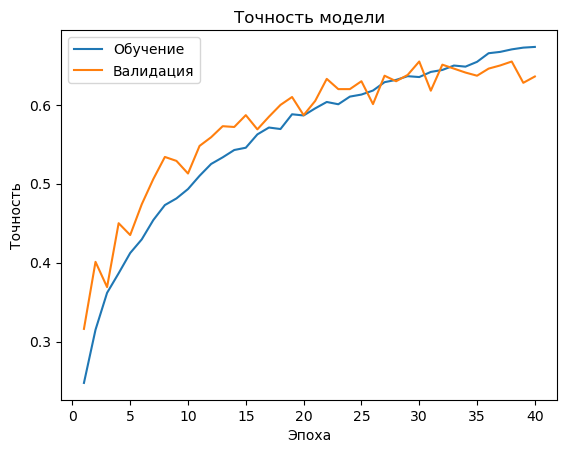

In [12]:
plt.title('Точность модели')
plt.plot(np.arange(1, len(results_baseline['mean_train_accs'])+1, dtype=np.int16), results_baseline['mean_train_accs'], label='Обучение')
plt.plot(np.arange(1, len(results_baseline['mean_train_accs'])+1, dtype=np.int16), results_baseline['mean_val_accs'], label='Валидация')
plt.xlabel('Эпоха')
plt.ylabel('Точность')
plt.legend()
# plt.semilogy()

In [13]:
print('Точность:', results_baseline['best_val_acc'])

Точность: 0.655


Видим, что точность значительно просела, когда мы увеличили число классов, придётся сделать модель поглубже, попробуем вариант Mid из прошлой работы

In [10]:
class MidLayer(nn.Module):
    def __init__(self, in_channels, out_channels, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.layer = nn.Sequential(
            BasicResBlock(in_channels, out_channels, stride=2, activation=nn.ELU()),
            BasicResBlock(out_channels, out_channels, activation=nn.ELU())
        )
    def forward(self, x):
        return self.layer(x)
    
class MidResNet(nn.Module):
    def __init__(self, class_num, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.layer1 = MidLayer(3, 64) #64, 32, 32
        self.layer2 = MidLayer(64, 128) #128, 16, 16
        self.layer3 = MidLayer(128, 256) #256, 8, 8
        self.avg = nn.AdaptiveAvgPool2d(output_size=(1,1))
        self.fc = nn.Linear(in_features=256, out_features=class_num)
        
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.avg(self.layer3(x))
        x = x.flatten(1)
        x = self.fc(x)
        return x

In [24]:
summary(MidResNet(CLASS_NUM))

Layer (type:depth-idx)                   Param #
├─MidLayer: 1-1                          --
|    └─Sequential: 2-1                   --
|    |    └─BasicResBlock: 3-1           39,360
|    |    └─BasicResBlock: 3-2           74,112
├─MidLayer: 1-2                          --
|    └─Sequential: 2-2                   --
|    |    └─BasicResBlock: 3-3           230,528
|    |    └─BasicResBlock: 3-4           295,680
├─MidLayer: 1-3                          --
|    └─Sequential: 2-3                   --
|    |    └─BasicResBlock: 3-5           919,808
|    |    └─BasicResBlock: 3-6           1,181,184
├─AdaptiveAvgPool2d: 1-4                 --
├─Linear: 1-5                            5,140
Total params: 2,745,812
Trainable params: 2,745,812
Non-trainable params: 0


Layer (type:depth-idx)                   Param #
├─MidLayer: 1-1                          --
|    └─Sequential: 2-1                   --
|    |    └─BasicResBlock: 3-1           39,360
|    |    └─BasicResBlock: 3-2           74,112
├─MidLayer: 1-2                          --
|    └─Sequential: 2-2                   --
|    |    └─BasicResBlock: 3-3           230,528
|    |    └─BasicResBlock: 3-4           295,680
├─MidLayer: 1-3                          --
|    └─Sequential: 2-3                   --
|    |    └─BasicResBlock: 3-5           919,808
|    |    └─BasicResBlock: 3-6           1,181,184
├─AdaptiveAvgPool2d: 1-4                 --
├─Linear: 1-5                            5,140
Total params: 2,745,812
Trainable params: 2,745,812
Non-trainable params: 0

In [25]:
def make_mid():
    return MidResNet(CLASS_NUM).to(device)

In [26]:
results_mid = train_multiple_runs(
    runs=1,
    model_constructor=make_mid,
    optimizer_constructor=init_AdamW,
    criterion=criterion,
    train_data_loader=train_data_loader,
    val_data_loader=val_data_loader,
    epoch_num=40,
    save_path= "./models/hw3/mid_best.pt"
)


===== Run 1/1 =====


Validating: 100%|██████████| 63/63 [00:01<00:00, 45.72it/s]


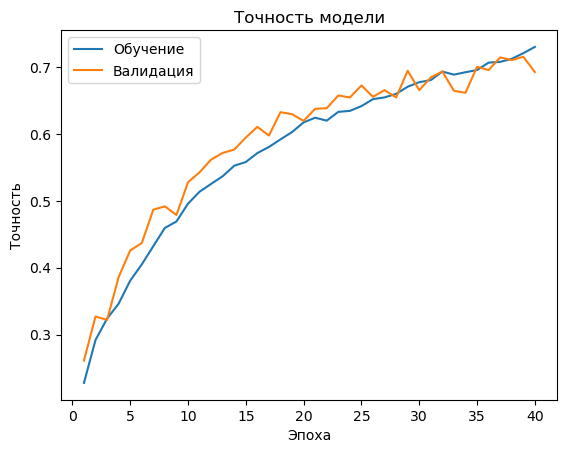

In [27]:
plt.title('Точность модели')
plt.plot(np.arange(1, len(results_mid['mean_train_accs'])+1, dtype=np.int16), results_mid['mean_train_accs'], label='Обучение')
plt.plot(np.arange(1, len(results_mid['mean_train_accs'])+1, dtype=np.int16), results_mid['mean_val_accs'], label='Валидация')
plt.xlabel('Эпоха')
plt.ylabel('Точность')
plt.legend()
# plt.semilogy()

In [11]:
class DeepLayer(nn.Module):
    def __init__(self, in_channels, out_channels, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.layer = nn.Sequential(
            BasicResBlock(in_channels, out_channels, stride=2, activation=nn.ELU()),
            BasicResBlock(out_channels, out_channels, activation=nn.ELU()),
            BasicResBlock(out_channels, out_channels, activation=nn.ELU())
        )
    def forward(self, x):
        return self.layer(x)
    
class DeepResNet(nn.Module):
    def __init__(self, class_num, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.layer1 = DeepLayer(3, 64) #64, 64, 64
        self.layer2 = DeepLayer(64, 128) #128, 32, 32
        self.layer3 = DeepLayer(128, 256) #256, 16, 16
        self.avg = nn.AdaptiveAvgPool2d(output_size=(1,1))
        self.fc = nn.Linear(in_features=256, out_features=class_num)
        
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.avg(self.layer3(x))
        x = x.flatten(1)
        x = self.fc(x)
        return x

In [54]:
summary(DeepResNet(CLASS_NUM))

Layer (type:depth-idx)                   Param #
├─DeepLayer: 1-1                         --
|    └─Sequential: 2-1                   --
|    |    └─BasicResBlock: 3-1           39,360
|    |    └─BasicResBlock: 3-2           74,112
|    |    └─BasicResBlock: 3-3           74,112
├─DeepLayer: 1-2                         --
|    └─Sequential: 2-2                   --
|    |    └─BasicResBlock: 3-4           230,528
|    |    └─BasicResBlock: 3-5           295,680
|    |    └─BasicResBlock: 3-6           295,680
├─DeepLayer: 1-3                         --
|    └─Sequential: 2-3                   --
|    |    └─BasicResBlock: 3-7           919,808
|    |    └─BasicResBlock: 3-8           1,181,184
|    |    └─BasicResBlock: 3-9           1,181,184
├─AdaptiveAvgPool2d: 1-4                 --
├─Linear: 1-5                            5,140
Total params: 4,296,788
Trainable params: 4,296,788
Non-trainable params: 0


Layer (type:depth-idx)                   Param #
├─DeepLayer: 1-1                         --
|    └─Sequential: 2-1                   --
|    |    └─BasicResBlock: 3-1           39,360
|    |    └─BasicResBlock: 3-2           74,112
|    |    └─BasicResBlock: 3-3           74,112
├─DeepLayer: 1-2                         --
|    └─Sequential: 2-2                   --
|    |    └─BasicResBlock: 3-4           230,528
|    |    └─BasicResBlock: 3-5           295,680
|    |    └─BasicResBlock: 3-6           295,680
├─DeepLayer: 1-3                         --
|    └─Sequential: 2-3                   --
|    |    └─BasicResBlock: 3-7           919,808
|    |    └─BasicResBlock: 3-8           1,181,184
|    |    └─BasicResBlock: 3-9           1,181,184
├─AdaptiveAvgPool2d: 1-4                 --
├─Linear: 1-5                            5,140
Total params: 4,296,788
Trainable params: 4,296,788
Non-trainable params: 0

In [53]:
def make_deep():
    return DeepResNet(CLASS_NUM).to(device)

In [32]:
results_deep = train_multiple_runs(
    runs=1,
    model_constructor=make_deep,
    optimizer_constructor=init_AdamW,
    criterion=criterion,
    train_data_loader=train_data_loader,
    val_data_loader=val_data_loader,
    epoch_num=40,
    save_path= "./models/hw3/deep_best.pt"
)


===== Run 1/1 =====


Validating: 100%|██████████| 63/63 [00:01<00:00, 33.96it/s]


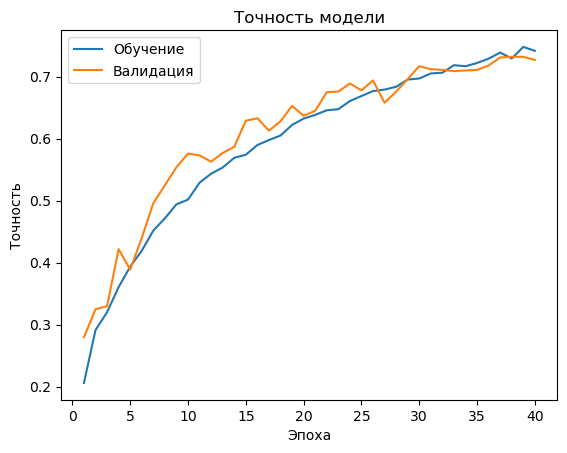

In [33]:
plt.title('Точность модели')
plt.plot(np.arange(1, len(results_deep['mean_train_accs'])+1, dtype=np.int16), results_deep['mean_train_accs'], label='Обучение')
plt.plot(np.arange(1, len(results_deep['mean_train_accs'])+1, dtype=np.int16), results_deep['mean_val_accs'], label='Валидация')
plt.xlabel('Эпоха')
plt.ylabel('Точность')
plt.legend()
# plt.semilogy()

Из-за того, что исходное изображение 128 x 128, финальные карты признаков получаются довольно большие и мы усредняем слишком большую карту. Чтобы уложиться в ограничение на 5 млн параметров попробуем добавить в конец неглубокий слой

In [12]:
class DeepLayer(nn.Module):
    def __init__(self, in_channels, out_channels, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.layer = nn.Sequential(
            BasicResBlock(in_channels, out_channels, stride=2, activation=nn.ELU()),
            BasicResBlock(out_channels, out_channels, activation=nn.ELU()),
            BasicResBlock(out_channels, out_channels, activation=nn.ELU())
        )
    def forward(self, x):
        return self.layer(x)
    
class ResNetRich(nn.Module):
    def __init__(self, class_num, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.layer1 = DeepLayer(3, 64) #64, 64, 64
        self.layer2 = DeepLayer(64, 128) #128, 32, 32
        self.layer3 = DeepLayer(128, 256) #256, 16, 16
        self.avg = nn.AdaptiveAvgPool2d((2,2))
        self.fc = nn.Linear(in_features=256*2*2 , out_features=class_num)
        
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.avg(self.layer3(x))
        x = torch.flatten(x, start_dim=1)
        x = self.fc(x)
        return x

In [50]:
summary(ResNetRich(CLASS_NUM))

Layer (type:depth-idx)                   Param #
├─DeepLayer: 1-1                         --
|    └─Sequential: 2-1                   --
|    |    └─BasicResBlock: 3-1           39,360
|    |    └─BasicResBlock: 3-2           74,112
|    |    └─BasicResBlock: 3-3           74,112
├─DeepLayer: 1-2                         --
|    └─Sequential: 2-2                   --
|    |    └─BasicResBlock: 3-4           230,528
|    |    └─BasicResBlock: 3-5           295,680
|    |    └─BasicResBlock: 3-6           295,680
├─DeepLayer: 1-3                         --
|    └─Sequential: 2-3                   --
|    |    └─BasicResBlock: 3-7           919,808
|    |    └─BasicResBlock: 3-8           1,181,184
|    |    └─BasicResBlock: 3-9           1,181,184
├─AdaptiveAvgPool2d: 1-4                 --
├─Linear: 1-5                            5,140
Total params: 4,296,788
Trainable params: 4,296,788
Non-trainable params: 0


Layer (type:depth-idx)                   Param #
├─DeepLayer: 1-1                         --
|    └─Sequential: 2-1                   --
|    |    └─BasicResBlock: 3-1           39,360
|    |    └─BasicResBlock: 3-2           74,112
|    |    └─BasicResBlock: 3-3           74,112
├─DeepLayer: 1-2                         --
|    └─Sequential: 2-2                   --
|    |    └─BasicResBlock: 3-4           230,528
|    |    └─BasicResBlock: 3-5           295,680
|    |    └─BasicResBlock: 3-6           295,680
├─DeepLayer: 1-3                         --
|    └─Sequential: 2-3                   --
|    |    └─BasicResBlock: 3-7           919,808
|    |    └─BasicResBlock: 3-8           1,181,184
|    |    └─BasicResBlock: 3-9           1,181,184
├─AdaptiveAvgPool2d: 1-4                 --
├─Linear: 1-5                            5,140
Total params: 4,296,788
Trainable params: 4,296,788
Non-trainable params: 0

In [32]:
def make_rich():
    return ResNetRich(CLASS_NUM).to(device)

In [33]:
results_rich = train_multiple_runs(
    runs=1,
    model_constructor=make_rich,
    optimizer_constructor=init_AdamW,
    criterion=criterion,
    train_data_loader=train_data_loader,
    val_data_loader=val_data_loader,
    epoch_num=40,
    save_path= "./models/hw3/rich_best.pt"
)


===== Run 1/1 =====


Validating: 100%|██████████| 63/63 [00:02<00:00, 30.27it/s]


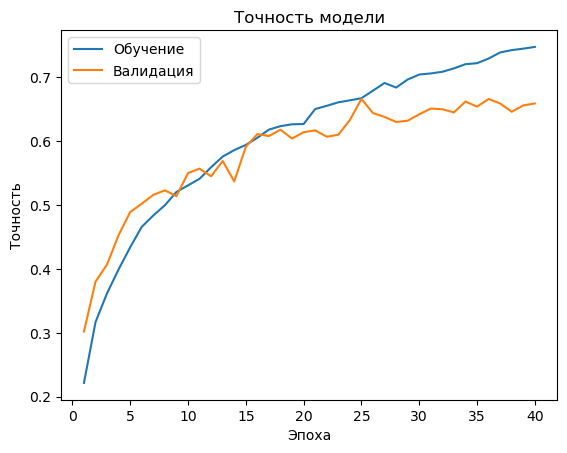

In [34]:
plt.title('Точность модели')
plt.plot(np.arange(1, len(results_rich['mean_train_accs'])+1, dtype=np.int16), results_rich['mean_train_accs'], label='Обучение')
plt.plot(np.arange(1, len(results_rich['mean_train_accs'])+1, dtype=np.int16), results_rich['mean_val_accs'], label='Валидация')
plt.xlabel('Эпоха')
plt.ylabel('Точность')
plt.legend()
# plt.semilogy()

Модель стала переобучаться. Попробовав разные конфигурации с условием на 5 млн параметров лучше сделать мы не можем, попробуем тогда сделать больше эпох обучения для глубокой модели

In [55]:
results_final = train_multiple_runs(
    runs=1,
    model_constructor=make_deep,
    optimizer_constructor=init_AdamW,
    criterion=criterion,
    train_data_loader=train_data_loader,
    val_data_loader=val_data_loader,
    epoch_num=60,
    save_path= "./models/hw3/deep_best.pt"
)


===== Run 1/1 =====


Validating: 100%|██████████| 63/63 [00:01<00:00, 36.60it/s]


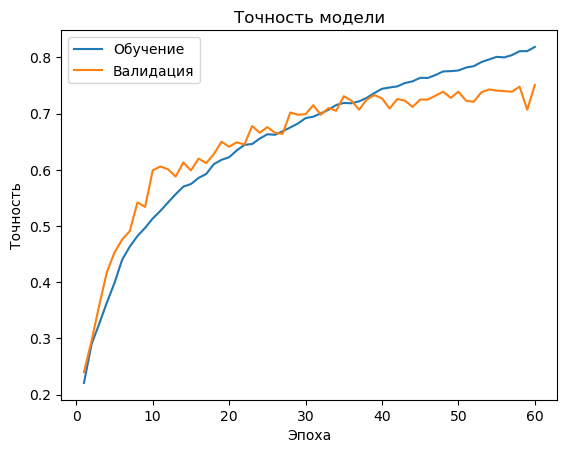

In [56]:
plt.title('Точность модели')
plt.plot(np.arange(1, len(results_final['mean_train_accs'])+1, dtype=np.int16), results_final['mean_train_accs'], label='Обучение')
plt.plot(np.arange(1, len(results_final['mean_train_accs'])+1, dtype=np.int16), results_final['mean_val_accs'], label='Валидация')
plt.xlabel('Эпоха')
plt.ylabel('Точность')
plt.legend()
# plt.semilogy()

In [57]:
print('Точность:', results_final['best_val_acc'])

Точность: 0.751


Лучше уже сделать не получилось и оказалось, что 40 эпох было оптимальным количеством эпох, дальше модель не обучалась. Точность 75% для относительно небольшой ResNet модели можно считать приемлемым результатом. Используем эту модель как бэкбон, ещё выведем график ошибки

[]

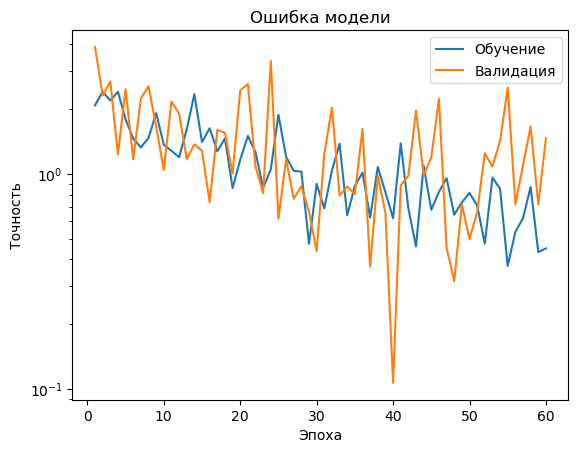

In [60]:
plt.title('Ошибка модели')
plt.plot(np.arange(1, len(results_final['mean_train_losses'])+1, dtype=np.int16), results_final['mean_train_losses'], label='Обучение')
plt.plot(np.arange(1, len(results_final['mean_train_losses'])+1, dtype=np.int16), results_final['mean_val_losses'], label='Валидация')
plt.xlabel('Эпоха')
plt.ylabel('Точность')
plt.legend()
plt.semilogy()

# Часть 2. Базовая U-Net на "Луне"

In [51]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchsummary import summary
import matplotlib.pyplot as plt
import numpy as np
import random
import torch

import torch.nn as nn
from tqdm import tqdm
from PIL import Image

## Данные

In [52]:
import cv2

class MoonDataset(Dataset):
    def __init__(self, root) -> None:
        super().__init__()
        self.root = root
        self.ground_masks = os.listdir(os.path.join(root, "ground"))
        self.images = os.listdir(os.path.join(root, "render"))
        self.tranform = None
        
    def add_transform(self, transform):
        self.tranform = transform
        
    def __getitem__(self, index):
        gt = cv2.imread(os.path.join(self.root, "ground", self.ground_masks[index]), cv2.IMREAD_GRAYSCALE)
        
        return gt
        
    def __len__(self) -> int:
        return len(self.ground_masks)

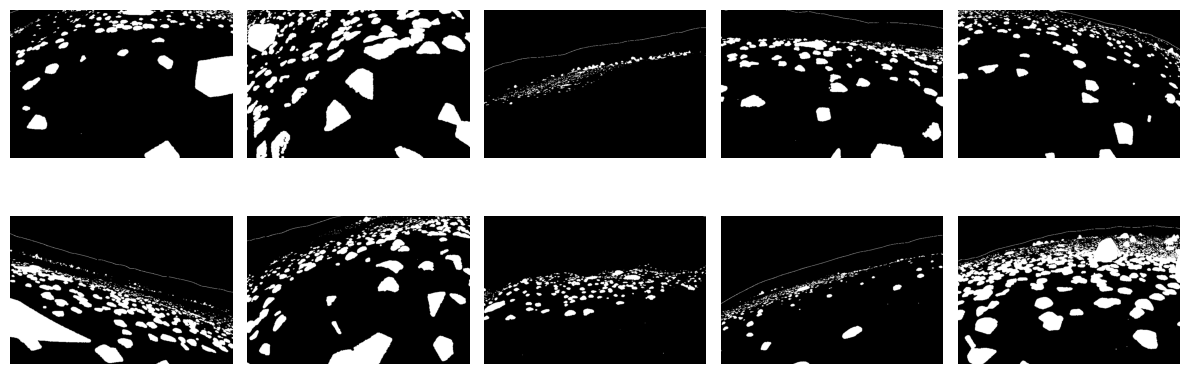

In [53]:
root = "./data/MOON_SEGMENTATION_BINARY/images"

ds_old = MoonDataset(root)
plt.figure(figsize=(12, 6))
for i in range(1,11):
    plt.subplot(2,5,i)
    plt.imshow(ds_old[i], cmap='gray')
    plt.axis('off')
    plt.tight_layout()

У нас имеются полосы на горизонте, подчистиим датасеты при помощи OpenCV. Добавим предобработку в датасет

In [54]:
class MoonDataset(Dataset):
    def __init__(self, root) -> None:
        super().__init__()
        self.root = root
        self.ground_masks = os.listdir(os.path.join(root, "ground"))
        self.images = os.listdir(os.path.join(root, "render"))
        self.tranform = None
        
    def add_transform(self, transform):
        self.tranform = transform
        
    def __getitem__(self, index):
        gt = cv2.imread(os.path.join(self.root, "ground", self.ground_masks[index]), cv2.IMREAD_GRAYSCALE)
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))
        _, thresh = cv2.threshold(gt, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        eroded = cv2.erode(thresh, kernel, iterations=1)
        gt = cv2.dilate(eroded, kernel, iterations=1)
        
        return gt
        
    def __len__(self) -> int:
        return len(self.ground_masks)
        

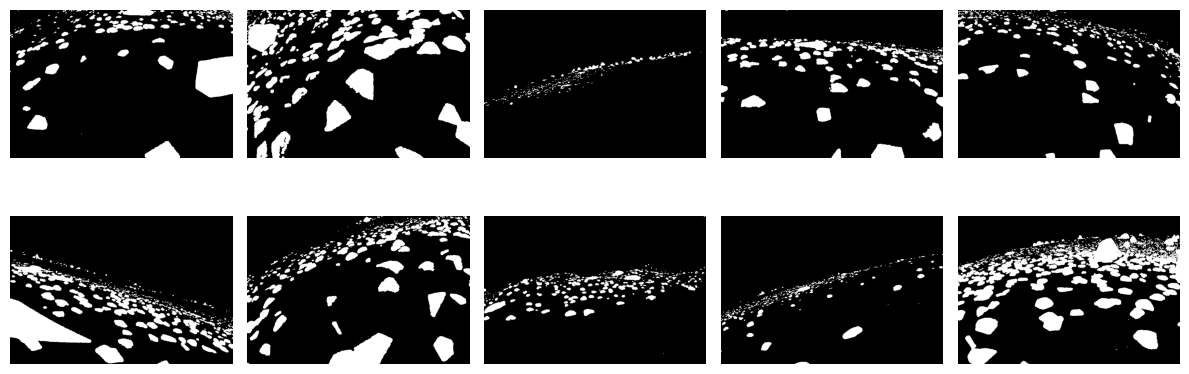

In [55]:
ds = MoonDataset(root)
plt.figure(figsize=(12, 6))
for i in range(1,11):
    plt.subplot(2,5,i)
    plt.imshow(ds[i], cmap='gray')
    plt.axis('off')
    plt.tight_layout()

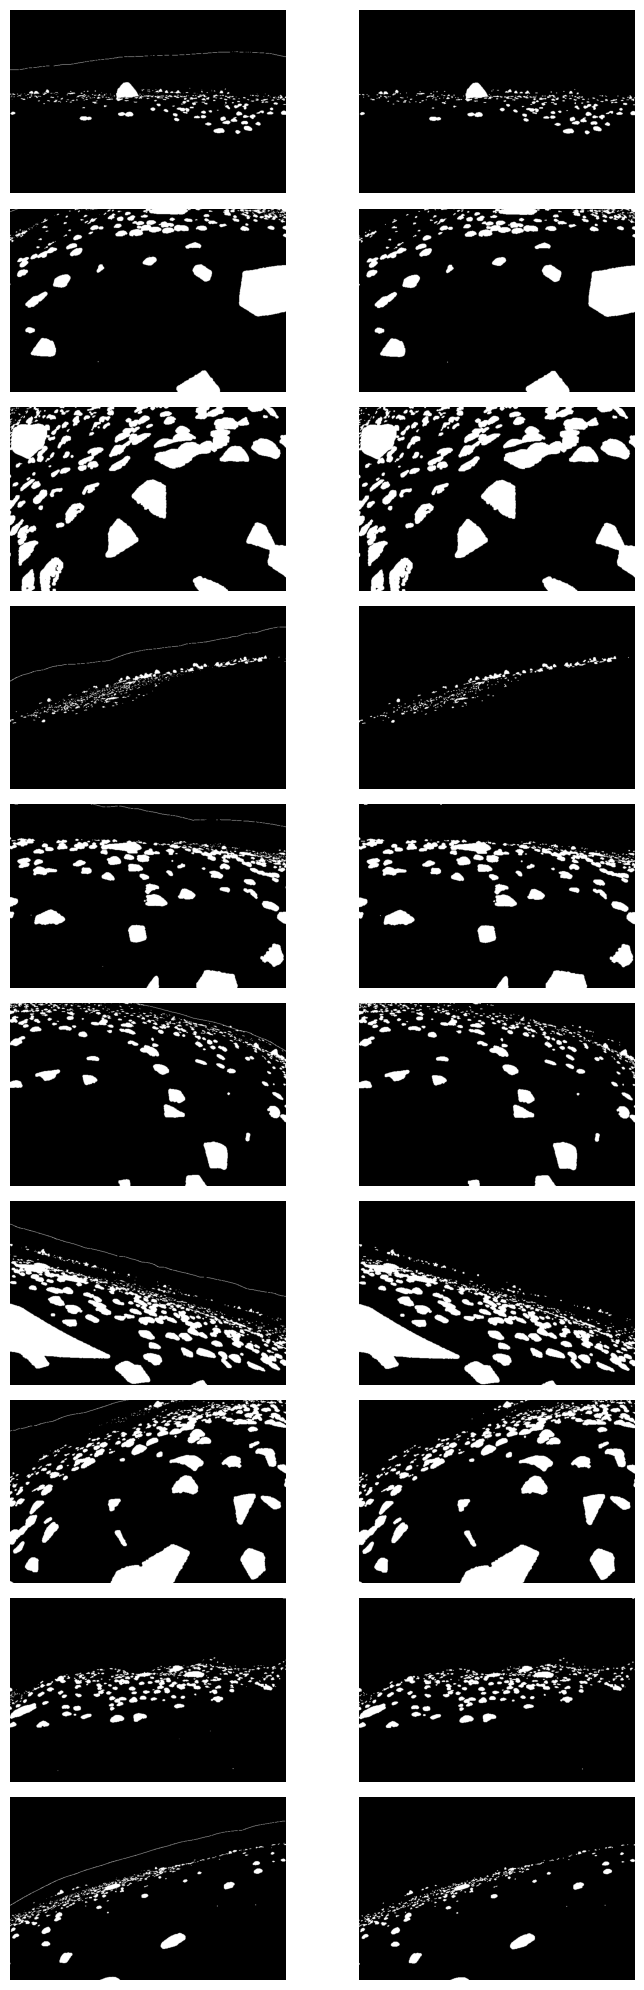

In [6]:
plt.figure(figsize=(8, 20))

for i in range(10):
    # слева: старый
    plt.subplot(10, 2, 2*i + 1)
    plt.imshow(ds_old[i], cmap='gray')
    plt.axis('off')

    # справа: новый
    plt.subplot(10, 2, 2*i + 2)
    plt.imshow(ds[i], cmap='gray')
    plt.axis('off')

plt.tight_layout()
plt.show()


Скорее всего есть риск утерять камни размера в 1-2 пикселя, однако если посмотреть на ряды 1,4 и 10, то утрата важной информации минимально. Зато благодаря такой обработке мы избавились от существенного артифакта. Теперь допишем наш датасет, часть реализации будет взята с семинара.

In [57]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

class MoonDataset(Dataset):
    def __init__(self, root, device, transform = None) -> None:
        super().__init__()
        self.root = root
        self.device = device
        self.ground_masks = os.listdir(os.path.join(root, "ground"))
        self.images = os.listdir(os.path.join(root, "render"))
        self.transform = transform
        
    def __getitem__(self, index):
        gt = cv2.imread(os.path.join(self.root, "ground", self.ground_masks[index]), cv2.IMREAD_GRAYSCALE)
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))
        eroded = cv2.erode(gt, kernel, iterations=1)
        gt = cv2.dilate(eroded, kernel, iterations=1)
        gt = (gt > 0).astype(np.float32)
        img = cv2.imread(os.path.join(self.root, "render", self.images[index]))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        if self.transform:
            sample = self.transform(image=img, mask = gt)
            img, gt = sample['image'], sample['mask']
            img = img.to(self.device)
            gt = gt.to(self.device)        
        return img, gt
        
    def __len__(self) -> int:
        return len(self.ground_masks)
        

In [58]:
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset
random.seed(52)
torch.manual_seed(52)
np.random.seed(52)

In [59]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
ds = MoonDataset(root, device)
indices = list(range(len(ds)))
train_indices, val_indices = train_test_split(indices, test_size=0.2, random_state=52)
train_transform = A.Compose([
    A.Resize(128, 128),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05,
                       rotate_limit=15, border_mode=cv2.BORDER_CONSTANT, p=0.5),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
])
val_transform = A.Compose([
    A.Resize(128, 128),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
])

train_data = Subset(MoonDataset(root,device, train_transform), train_indices)
val_data = Subset(MoonDataset(root,device, val_transform), val_indices)

train_data_loader = DataLoader(train_data, batch_size=16, shuffle=True)
val_data_loader = DataLoader(val_data, batch_size=16, shuffle=True)

c:\Users\roman\miniconda3\envs\RL\Lib\site-packages\albumentations\core\validation.py:132: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


## Модель

Требования к архитектуре U-Net:
* Глубина: 4 уровня down/4 up (энкодер-декодер с skip-связями).
* Базовые каналы на первом уровне: 32 или 64 (по желанию можно выбрать свое количество каналов, но надо будет объяснить).
* Даунсемплинг: stride 2 или MaxPool.
* Итоговый слой: 1 канал с сигмоидой (бинарная сегментация).
* Ограничение на количество параметров: до ~2.5M (рекомендуется укладываться, но допускается ±10%).
* Вход: 128×128×3.

Сделаем модель по тому подобию, что было рассмотрено на семинаре.

In [61]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    
    def forward(self, x):
        return self.double_conv(x)

class UNet(nn.Module):

    def __init__(self, in_channels=3):
        super(UNet, self).__init__()
        self.conv1 = DoubleConv(in_channels, 32)
        self.maxpool = nn.MaxPool2d(2)
        self.conv2 = DoubleConv(32, 64)
        self.conv3 = DoubleConv(64, 128)
        self.conv4 = DoubleConv(128, 256)
        
        self.conv_adapt = nn.Conv2d(3, 16, kernel_size=1)
        
        self.convtranspose1 = nn.ConvTranspose2d(256, 128,kernel_size=2,stride=2)
        self.conv_up1 = DoubleConv(256, 128)
        self.convtranspose2 = nn.ConvTranspose2d(128, 64,kernel_size=2,stride=2)
        self.conv_up2 = DoubleConv(128, 64)
        self.convtranspose3 = nn.ConvTranspose2d(64, 32,kernel_size=2,stride=2)
        self.conv_up3 = DoubleConv(64, 32)
        self.convtranspose4 = nn.ConvTranspose2d(32, 16,kernel_size=2,stride=2)
        self.conv_up4 = DoubleConv(32, 1)
        
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        x_128 = x
        x = self.conv1(x) #32 x 128 x 128
        x_64 = self.maxpool(x) # 32 x 64 x 64
        x = self.conv2(x_64)  # 64 x 64 x 64
        x_32 = self.maxpool(x) # 64 x 32 x 32
        
        x = self.conv3(x_32)    # 128 x 32 x 32    
        x_16 = self.maxpool(x)  # 128 x 16 x 16
        
        x = self.conv4(x_16)    # 256 x 16 x 16
        x_8 = self.maxpool(x)  # 256 x 8 x  8
        
        up_1_16 = self.convtranspose1(x_8) # 128 x 16 x 16
        conc_up1_16 = torch.cat([up_1_16, x_16], dim=1) # 256 x 16 x 16
        up_1_16 = self.conv_up1(conc_up1_16)    # 128 x 16 x 16
        
        up_2_32 = self.convtranspose2(up_1_16) # 64 x 32 x 32
        conc_up2_32 = torch.cat([up_2_32, x_32], dim=1) # 128 x 32 x 32
        up_2_32 = self.conv_up2(conc_up2_32) # 64 x 32 x 32
        
        up_3_64 = self.convtranspose3(up_2_32) # 32 x 64 x 64
        conc_up3_64 = torch.cat([up_3_64, x_64], dim=1) # 64 x 64 x 64
        up_3_64 = self.conv_up3(conc_up3_64) # 32 x 64 x 64
        
        up_4_128 = self.convtranspose4(up_3_64) # 16 x 128 x 128
        conc_up4_128 = torch.cat([up_4_128, self.conv_adapt(x_128)], dim=1) # 32 x 128 x 128
        up_4_128 = self.conv_up4(conc_up4_128) # 1 x 128 x 128 
        up_4_128 = up_4_128.squeeze(1)
        logits = up_4_128
        probs = self.sigmoid(logits)
        return logits, probs

In [11]:
summary(UNet())

Layer (type:depth-idx)                   Param #
├─DoubleConv: 1-1                        --
|    └─Sequential: 2-1                   --
|    |    └─Conv2d: 3-1                  896
|    |    └─BatchNorm2d: 3-2             64
|    |    └─ReLU: 3-3                    --
|    |    └─Conv2d: 3-4                  9,248
|    |    └─BatchNorm2d: 3-5             64
|    |    └─ReLU: 3-6                    --
├─MaxPool2d: 1-2                         --
├─DoubleConv: 1-3                        --
|    └─Sequential: 2-2                   --
|    |    └─Conv2d: 3-7                  18,496
|    |    └─BatchNorm2d: 3-8             128
|    |    └─ReLU: 3-9                    --
|    |    └─Conv2d: 3-10                 36,928
|    |    └─BatchNorm2d: 3-11            128
|    |    └─ReLU: 3-12                   --
├─DoubleConv: 1-4                        --
|    └─Sequential: 2-3                   --
|    |    └─Conv2d: 3-13                 73,856
|    |    └─BatchNorm2d: 3-14            256
|    |  

Layer (type:depth-idx)                   Param #
├─DoubleConv: 1-1                        --
|    └─Sequential: 2-1                   --
|    |    └─Conv2d: 3-1                  896
|    |    └─BatchNorm2d: 3-2             64
|    |    └─ReLU: 3-3                    --
|    |    └─Conv2d: 3-4                  9,248
|    |    └─BatchNorm2d: 3-5             64
|    |    └─ReLU: 3-6                    --
├─MaxPool2d: 1-2                         --
├─DoubleConv: 1-3                        --
|    └─Sequential: 2-2                   --
|    |    └─Conv2d: 3-7                  18,496
|    |    └─BatchNorm2d: 3-8             128
|    |    └─ReLU: 3-9                    --
|    |    └─Conv2d: 3-10                 36,928
|    |    └─BatchNorm2d: 3-11            128
|    |    └─ReLU: 3-12                   --
├─DoubleConv: 1-4                        --
|    └─Sequential: 2-3                   --
|    |    └─Conv2d: 3-13                 73,856
|    |    └─BatchNorm2d: 3-14            256
|    |  

Теперь подготовим подсчёт метрик и ошибки, чтобы написать цикл обучения. Для этого надо реализовать класс подсчёта dice. Для численной стабильности введём параметр, чтобы знаменатель не обращался в ноль. Выбирать лучшую модель будем по IoU

In [62]:
from torch.nn import BCEWithLogitsLoss

class DiceLoss(nn.Module):
    def __init__(self, smooth: float = 1.0):
        super().__init__()
        self.smooth = smooth

    def forward(self, logits, targets):
        probs = torch.sigmoid(logits)
        intersection = (probs * targets).sum(dim=1)
        union = probs.sum(dim=1) + targets.sum(dim=1)

        dice = (2. * intersection + self.smooth) / (union + self.smooth)
        return 1 - dice.mean()

def calc_loss(logits, targets):
    """Принимаем на вход размер B x H x W"""
    if len(logits.shape) == 4:
        logits = logits.squeeze(1)
    if len(targets.shape) == 4:
        targets = targets.squeeze(1)
    logits = logits.contiguous().view(logits.size(0), -1)      # B x H*W
    targets = targets.contiguous().view(targets.size(0), -1)  # B x H*W
    dice = DiceLoss()
    bce = BCEWithLogitsLoss()
    return dice(logits, targets) + bce(logits, targets)

def calc_metrics(probs, targets, thresh=0.5, eps = 1e-5):
    """Входы размера B x H x W"""
    if len(probs.shape) == 4:
        probs = probs.squeeze(1)
    if len(targets.shape) == 4:
        targets = targets.squeeze(1)
    targets = targets.float()
    preds = (probs > thresh).float()
    preds = preds.view(preds.size(0), -1)
    targets = targets.view(targets.size(0), -1)
    
    tp = (preds * targets).sum(dim=-1)
    fp = (preds * (1 - targets)).sum(dim=-1)
    tn = ((1 - preds) * (1 - targets)).sum(dim=-1)
    fn = ((1 - preds) * targets).sum(dim=-1)
    
    iou = (tp + eps) / (tp + fp + fn + eps)
    dice = (2 * tp + eps) / (2 * tp + fp + fn + eps)
    pixel_acc = (tp + tn + eps) / (tp + tn + fn + fp + eps)
    
    return {
        "iou" : iou.mean(),
        "dice" : dice.mean(),
        "pixel_acc" : pixel_acc.mean()
    }
    
    

def evaluate(model, val_data_loader, criterion):
    model.eval()
    iou_history = []
    dice_history = []
    pixel_acc_history = []
    loss_history = []
    
    with torch.no_grad():
        for images, labels in tqdm(iterable=val_data_loader, desc=f"Validating"):
            logits, probs = model(images)
            loss = criterion(logits, labels)
            metrics = calc_metrics(probs, labels)
            loss_history.append(loss.item())
            iou_history.append(metrics['iou'].item())
            dice_history.append(metrics['dice'].item())
            pixel_acc_history.append(metrics['pixel_acc'].item())
    return {
        "iou" : np.mean(iou_history),
        "dice" : np.mean(dice_history),
        "pixel_acc" : np.mean(pixel_acc_history),
        "loss" : np.mean(loss_history)
    }

from copy import deepcopy

def train_one_run(model, optimizer, criterion, evaluation, train_data_loader, val_data_loader, save_path, epoch_num=20):
    train_iou_history = []
    train_dice_history = []
    train_pixel_acc_history = []
    train_loss_history = []
    val_loss_history = []
    val_iou_history = []
    val_dice_history = []
    val_pixel_acc_history = []
    val_loss_history = []

    best_val_iou = 0.0
    best_state_dict = None

    for epoch in range(epoch_num):
        model.train()
        subEpoch_iou = []
        subEpoch_dice = []
        subEpoch_pixel_acc = []
        subEpoch_train_loss = []
        
        for images, labels in tqdm(desc=f"Training epoch {epoch + 1}", iterable=train_data_loader):
            optimizer.zero_grad()
            logits, probs = model(images)
            train_metrics = calc_metrics(probs, labels)
            loss = criterion(logits, labels)
            loss.backward()
            optimizer.step()
            subEpoch_iou.append(train_metrics['iou'].item())
            subEpoch_dice.append(train_metrics['dice'].item())
            subEpoch_pixel_acc.append(train_metrics['pixel_acc'].item())
            subEpoch_train_loss.append(loss.item())
        train_iou_history.append(np.mean(subEpoch_iou))
        train_dice_history.append(np.mean(subEpoch_dice))
        train_pixel_acc_history.append(np.mean(subEpoch_pixel_acc))
        train_loss_history.append(np.mean(subEpoch_train_loss))

        model.eval()
        val_metrics = evaluation(model, val_data_loader, criterion)
        val_iou_history.append(val_metrics['iou'])
        val_dice_history.append(val_metrics['dice'])
        val_pixel_acc_history.append(val_metrics['pixel_acc'])
        val_loss_history.append(val_metrics['loss'])

        if val_metrics['iou'] > best_val_iou:
            best_val_iou = val_metrics['iou']
            best_state_dict = deepcopy(model.state_dict())
            torch.save(model.state_dict(), save_path)
    train_metrics_history = {
        'iou' : train_iou_history,
        'dice' : train_dice_history,
        'pixel_acc' : train_pixel_acc_history
    }
    val_metrics_history = {
        'iou' : val_iou_history,
        'dice' : val_dice_history,
        'pixel_acc' : val_pixel_acc_history
    }
    return {
        "best_val_iou" : best_val_iou,
        "best_state_dict": best_state_dict,
        "train_loss_history": train_loss_history,
        "val_loss_history": val_loss_history,
        "train_metrics_history": train_metrics_history,
        "val_metrics_history": val_metrics_history,
    }

def reorganize_metrics(results):
    iou = []
    dice = []
    pixel_acc = []
    for run in results:
        iou.append(run['iou'])
        dice.append(run['dice'])
        pixel_acc.append(run['pixel_acc'])
    return {
        "iou" : iou,
        "dice" : dice,
        "pixel_acc" : pixel_acc
    }    

def train_multiple_runs(runs, model_constructor, optimizer_constructor, criterion, evaluation, train_data_loader, val_data_loader, save_path, epoch_num=20):
    all_train_losses = []
    all_val_losses = []
    all_train_metrics = []
    all_val_metrics = []
    all_train_iou = []
    all_val_iou = []

    best_overall_val_iou = 0.0
    best_overall_state_dict = None

    for run in range(runs):
        print(f"\n===== Run {run + 1}/{runs} =====")
        model = model_constructor()
        optimizer = optimizer_constructor(model)

        result = train_one_run(
            model=model,
            optimizer=optimizer,
            criterion=criterion,
            evaluation=evaluation,
            train_data_loader=train_data_loader,
            val_data_loader=val_data_loader,
            epoch_num=epoch_num,
            save_path = save_path
        )

        all_train_losses.append(result["train_loss_history"])
        all_val_losses.append(result["val_loss_history"])
        all_train_metrics.append(result["train_metrics_history"])
        all_val_metrics.append(result["val_metrics_history"])
        all_train_iou.append(result["train_metrics_history"]["iou"])
        all_val_iou.append(result["val_metrics_history"]["iou"])

        if result["best_val_iou"] > best_overall_val_iou:
            best_overall_val_iou = result["best_val_iou"]
            best_overall_state_dict = deepcopy(result["best_state_dict"])

    mean_train_losses = np.mean(np.array(all_train_losses), axis=0)
    mean_val_losses = np.mean(np.array(all_val_losses), axis=0)
    mean_train_iou = np.mean(np.array(all_train_iou), axis=0)
    mean_val_iou = np.mean(np.array(all_val_iou), axis=0)

    best_model = model_constructor()
    best_model.load_state_dict(best_overall_state_dict)

    return {
        "best_model": best_model,                    
        "best_val_iou": best_overall_val_iou,
        "mean_train_losses": mean_train_losses,      
        "mean_val_losses": mean_val_losses,
        "mean_train_iou": mean_train_iou,
        "mean_val_iou": mean_val_iou,
        "all_histories": {
            "train_losses": all_train_losses,
            "val_losses": all_val_losses,
            "val_metrics": reorganize_metrics(all_val_metrics),
            "train_metrics": reorganize_metrics(all_train_metrics),
        },
    }


In [63]:
def make_unet():
    return UNet().to(device)

def init_AdamW(model):
    return torch.optim.AdamW(model.parameters(), lr=1e-3, 
                             weight_decay=1e-5)
    
def init_Adam(model):
    return torch.optim.Adam(model.parameters(), lr=1e-3)    

In [22]:
results_unet = train_multiple_runs(
    runs=3,
    model_constructor=make_unet,
    optimizer_constructor=init_AdamW,
    criterion=calc_loss,
    evaluation=evaluate,
    train_data_loader=train_data_loader,
    val_data_loader=val_data_loader,
    epoch_num=100,
    save_path= "./models/hw3/unet_best.pt"
)


===== Run 1/3 =====


Validating: 100%|██████████| 13/13 [00:01<00:00,  7.63it/s]



===== Run 2/3 =====


Validating: 100%|██████████| 13/13 [00:01<00:00,  7.69it/s]



===== Run 3/3 =====


Validating: 100%|██████████| 13/13 [00:01<00:00,  7.61it/s]


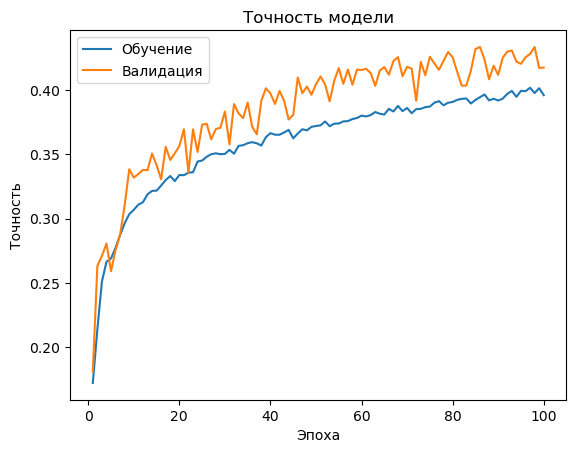

In [23]:
plt.title('Точность модели')
plt.plot(np.arange(1, len(results_unet['mean_train_iou'])+1, dtype=np.int16), results_unet['mean_train_iou'], label='Обучение')
plt.plot(np.arange(1, len(results_unet['mean_train_iou'])+1, dtype=np.int16), results_unet['mean_val_iou'], label='Валидация')
plt.xlabel('Эпоха')
plt.ylabel('Точность')
plt.legend()
# plt.semilogy()

Попробуем улучшить результат тем, что убёрём адаптационную свёртку, чтобы подавать исходное изображение в последний блок

In [38]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    
    def forward(self, x):
        return self.double_conv(x)

class UNetNA(nn.Module):

    def __init__(self, in_channels=3):
        super(UNetNA, self).__init__()
        self.conv1 = DoubleConv(in_channels, 32)
        self.maxpool = nn.MaxPool2d(2)
        self.conv2 = DoubleConv(32, 64)
        self.conv3 = DoubleConv(64, 128)
        self.conv4 = DoubleConv(128, 256)
        
        self.convtranspose1 = nn.ConvTranspose2d(256, 128,kernel_size=2,stride=2)
        self.conv_up1 = DoubleConv(256, 128)
        self.convtranspose2 = nn.ConvTranspose2d(128, 64,kernel_size=2,stride=2)
        self.conv_up2 = DoubleConv(128, 64)
        self.convtranspose3 = nn.ConvTranspose2d(64, 32,kernel_size=2,stride=2)
        self.conv_up3 = DoubleConv(64, 32)
        self.convtranspose4 = nn.ConvTranspose2d(32, 16,kernel_size=2,stride=2)
        self.conv_up4 = DoubleConv(19, 1)
        
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        x_128 = x
        x = self.conv1(x) #32 x 128 x 128
        x_64 = self.maxpool(x) # 32 x 64 x 64
        x = self.conv2(x_64)  # 64 x 64 x 64
        x_32 = self.maxpool(x) # 64 x 32 x 32
        
        x = self.conv3(x_32)    # 128 x 32 x 32    
        x_16 = self.maxpool(x)  # 128 x 16 x 16
        
        x = self.conv4(x_16)    # 256 x 16 x 16
        x_8 = self.maxpool(x)  # 256 x 8 x  8
        
        up_1_16 = self.convtranspose1(x_8) # 128 x 16 x 16
        conc_up1_16 = torch.cat([up_1_16, x_16], dim=1) # 256 x 16 x 16
        up_1_16 = self.conv_up1(conc_up1_16)    # 128 x 16 x 16
        
        up_2_32 = self.convtranspose2(up_1_16) # 64 x 32 x 32
        conc_up2_32 = torch.cat([up_2_32, x_32], dim=1) # 128 x 32 x 32
        up_2_32 = self.conv_up2(conc_up2_32) # 64 x 32 x 32
        
        up_3_64 = self.convtranspose3(up_2_32) # 32 x 64 x 64
        conc_up3_64 = torch.cat([up_3_64, x_64], dim=1) # 64 x 64 x 64
        up_3_64 = self.conv_up3(conc_up3_64) # 32 x 64 x 64
        
        up_4_128 = self.convtranspose4(up_3_64) # 16 x 128 x 128
        conc_up4_128 = torch.cat([up_4_128, x_128], dim=1) # 19 x 128 x 128
        up_4_128 = self.conv_up4(conc_up4_128) # 1 x 128 x 128 
        up_4_128 = up_4_128.squeeze(1)
        logits = up_4_128
        probs = self.sigmoid(logits)
        return logits, probs

In [39]:
def make_unet_na():
    return UNetNA().to(device)

results_unet_na = train_multiple_runs(
    runs=3,
    model_constructor=make_unet_na,
    optimizer_constructor=init_AdamW,
    criterion=calc_loss,
    evaluation=evaluate,
    train_data_loader=train_data_loader,
    val_data_loader=val_data_loader,
    epoch_num=100,
    save_path= "./models/hw3/unet_na_best.pt"
)


===== Run 1/3 =====


Validating: 100%|██████████| 13/13 [00:01<00:00,  7.27it/s]



===== Run 2/3 =====


Validating: 100%|██████████| 13/13 [00:01<00:00,  7.55it/s]



===== Run 3/3 =====


Validating: 100%|██████████| 13/13 [00:01<00:00,  7.63it/s]


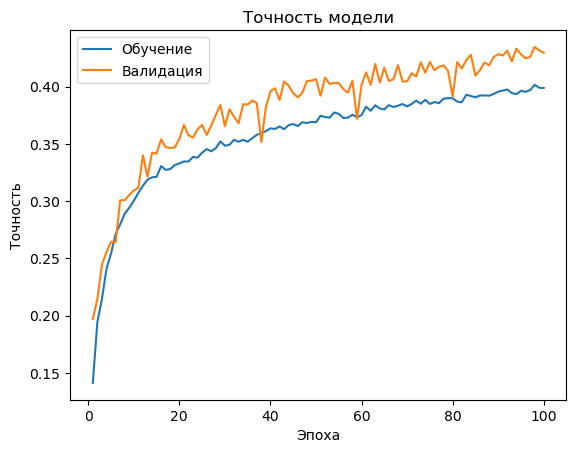

In [40]:
plt.title('Точность модели')
plt.plot(np.arange(1, len(results_unet_na['mean_train_iou'])+1, dtype=np.int16), results_unet_na['mean_train_iou'], label='Обучение')
plt.plot(np.arange(1, len(results_unet_na['mean_train_iou'])+1, dtype=np.int16), results_unet_na['mean_val_iou'], label='Валидация')
plt.xlabel('Эпоха')
plt.ylabel('Точность')
plt.legend()
# plt.semilogy()

In [41]:
print('IoU UNet с адаптером:', results_unet['best_val_iou'])
print('IoU UNet без адаптера:', results_unet_na['best_val_iou'])

IoU UNet с адаптером: 0.44184325062311613
IoU UNet без адаптера: 0.4426661959061256


Модели практически идентичные, так что улучшить ситуацию не удалось. Будем использовать первую версию модели. Посмотрим на другие метрики первой модели.

In [64]:
def visualize_metrics(results):
    train_metrics = results['all_histories']['train_metrics']
    val_metrics = results['all_histories']['val_metrics']
    train_data = {}
    val_data = {}    
    for metric in train_metrics.keys():
        train_metric = np.array(train_metrics[metric])
        train_metric = np.mean(train_metric,axis=0)
        val_metric = np.array(val_metrics[metric])
        val_metric = np.mean(val_metric,axis=0)
        train_data[metric] = train_metric
        val_data[metric] = val_metric
        
        plt.figure()
        plt.title("Метрика " + metric)
        plt.plot(np.arange(1, len(train_metric)+1), train_metric, label='Обучение')
        plt.plot(np.arange(1, len(val_metric)+1), val_metric, label='Валидация')
        plt.xlabel('Эпоха')
        plt.legend()
        
    plt.figure()
    plt.title('Ошибка')
    plt.plot(np.arange(1, len(results['mean_train_losses'])+1), results['mean_train_losses'], label='Обучение')
    plt.plot(np.arange(1, len(results['mean_val_losses'])+1), results['mean_val_losses'], label='Валидация')
    plt.xlabel('Эпоха')
    plt.legend()
    plt.semilogy()

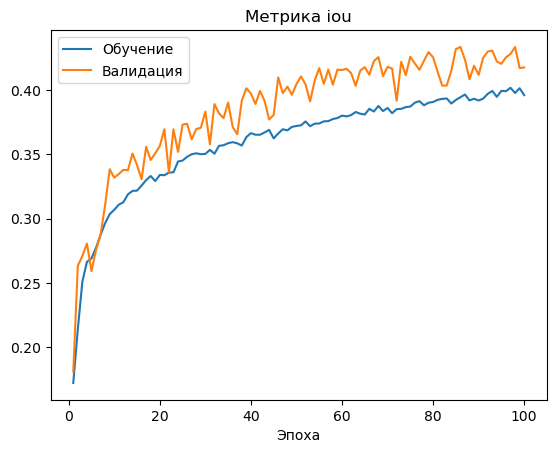

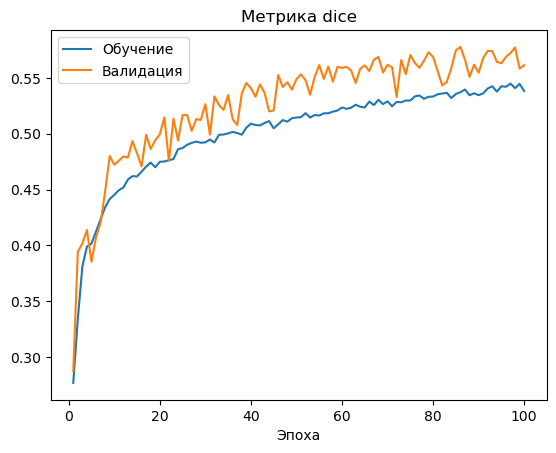

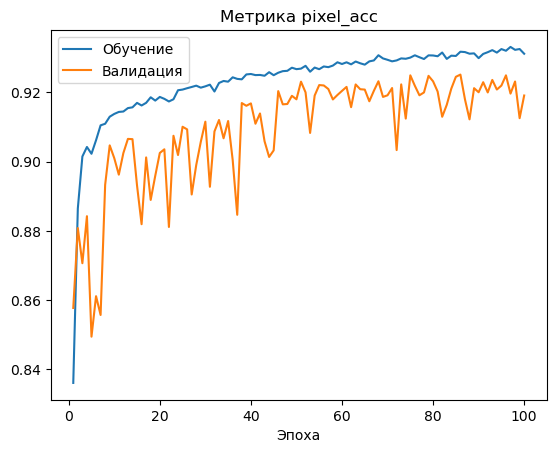

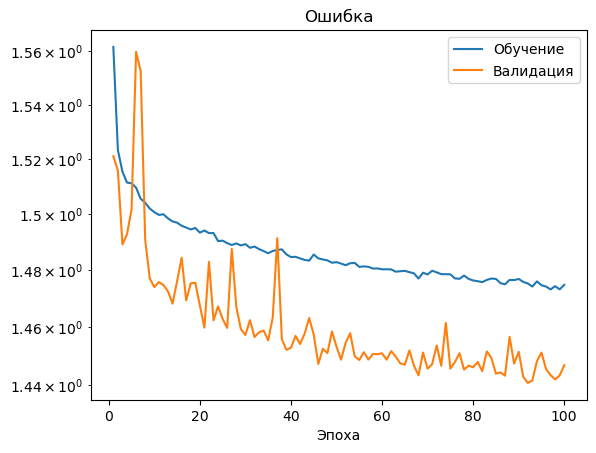

In [79]:
visualize_metrics(results_unet)

Визуализируем примеры

In [91]:
def show_examples(model):
    val_transform_show = A.Compose([
        A.Resize(128, 128),
        ToTensorV2(),
    ])
    val_data_show = Subset(MoonDataset(root,device, val_transform_show), val_indices)
    val_data_loader_show = DataLoader(val_data_show,batch_size=5, shuffle=False)
    val_data_loader_ = DataLoader(val_data, batch_size=5, shuffle=False)
    
    model.eval()
    
    img_show, _ = next(iter(val_data_loader_show))
    img_inf, gt = next(iter(val_data_loader_))
    _, probs = model(img_inf)
    probs = probs.cpu().detach().numpy()
    preds = (probs > 0.5).astype(int)
    img_show = img_show.cpu().detach().numpy()
    gt = gt.cpu().detach().numpy()
    for i in range(5):
        img = img_show[i]
        img = np.transpose(img, (1, 2, 0))
        
        plt.figure()
        plt.subplot(1, 3, 1)
        plt.imshow(img)
        plt.axis('off')
        plt.tight_layout()
        plt.subplot(1, 3, 2)
        plt.imshow(gt[i], cmap='gray')
        plt.axis('off')
        plt.tight_layout()
        plt.subplot(1, 3, 3)
        plt.imshow(preds[i], cmap='gray')
        plt.axis('off')
        plt.tight_layout()

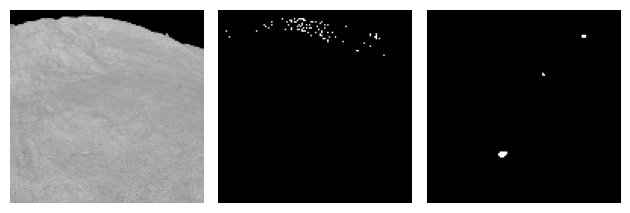

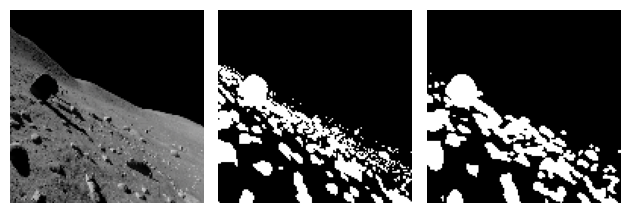

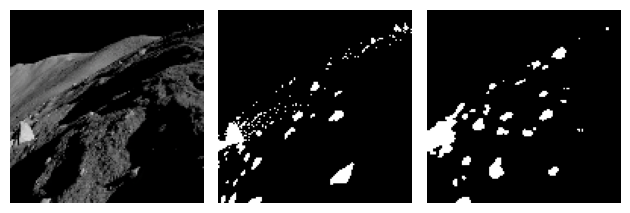

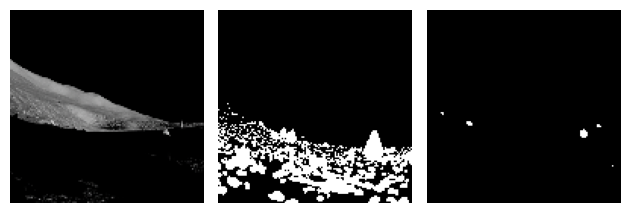

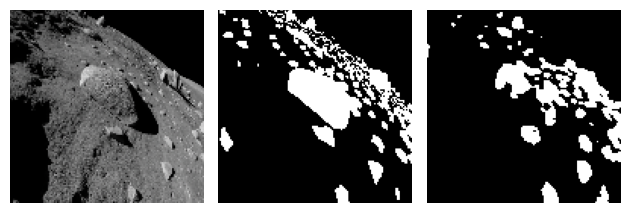

In [92]:
best_unet = results_unet['best_model']

show_examples(best_unet)

# Часть 3

Теперь сделаем модель с бэкбоном по следующему принципу: зафиксируем архитектуру слоёв декодера (количество каналов), чтобы признаки из бэкбона подошли, будем использовать 1х1 свёртки, где это нужно. Также в исходном UNet у нас имеется 4 skip-соединения, чтобы было четыре стадии, на выходе энкодера добавим дополнительный maxpool. Убедимся, чтобы бэкбон был заморожен

In [75]:
class BasicResBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, activation = nn.ReLU(), *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, stride=stride),
            nn.BatchNorm2d(out_channels),
            activation
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(out_channels),
        )
        self.downsample = None
        if in_channels != out_channels or stride > 1:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride),
                nn.BatchNorm2d(out_channels)
            )
        self.activation = activation
            
    def forward(self, x):
        identity = x
        res = self.conv1(x)
        res = self.conv2(res)
        if self.downsample:
            identity = self.downsample(identity)
        res = res + identity
        res = self.activation(res)
        return res

class DeepLayer(nn.Module):
    def __init__(self, in_channels, out_channels, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.layer = nn.Sequential(
            BasicResBlock(in_channels, out_channels, stride=2, activation=nn.ELU()),
            BasicResBlock(out_channels, out_channels, activation=nn.ELU()),
            BasicResBlock(out_channels, out_channels, activation=nn.ELU())
        )
    def forward(self, x):
        return self.layer(x)
    
class BackBone(nn.Module):
    def __init__(self, class_num, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.layer1 = DeepLayer(3, 64) #64, 64, 64
        self.layer2 = DeepLayer(64, 128) #128, 32, 32
        self.layer3 = DeepLayer(128, 256) #256, 16, 16
        self.avg = nn.AdaptiveAvgPool2d(output_size=(1,1))
        self.fc = nn.Linear(in_features=256, out_features=class_num)
        
    #возвращаем только результаты свёрток
    def forward(self, x):
        x1 = self.layer1(x) #64, 64, 64
        x2 = self.layer2(x1) #128, 32, 32
        x3 = self.layer3(x2) #256, 16, 16
        x = self.avg(x3)
        x = x.flatten(1)
        x = self.fc(x)
        return x1, x2, x3

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    
    def forward(self, x):
        return self.double_conv(x)

class UNet(nn.Module):

    def __init__(self, in_channels=3):
        super(UNet, self).__init__()
        self.conv1 = DoubleConv(in_channels, 32)
        self.maxpool = nn.MaxPool2d(2)
        self.conv2 = DoubleConv(32, 64)
        self.conv3 = DoubleConv(64, 128)
        self.conv4 = DoubleConv(128, 256)
        
        self.conv_adapt = nn.Conv2d(3, 16, kernel_size=1)
        
        self.convtranspose1 = nn.ConvTranspose2d(256, 128,kernel_size=2,stride=2)
        self.conv_up1 = DoubleConv(256, 128)
        self.convtranspose2 = nn.ConvTranspose2d(128, 64,kernel_size=2,stride=2)
        self.conv_up2 = DoubleConv(128, 64)
        self.convtranspose3 = nn.ConvTranspose2d(64, 32,kernel_size=2,stride=2)
        self.conv_up3 = DoubleConv(64, 32)
        self.convtranspose4 = nn.ConvTranspose2d(32, 16,kernel_size=2,stride=2)
        self.conv_up4 = DoubleConv(32, 1)
        
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        x_128 = x
        x = self.conv1(x) #32 x 128 x 128
        x_64 = self.maxpool(x) # 32 x 64 x 64
        x = self.conv2(x_64)  # 64 x 64 x 64
        x_32 = self.maxpool(x) # 64 x 32 x 32
        
        x = self.conv3(x_32)    # 128 x 32 x 32    
        x_16 = self.maxpool(x)  # 128 x 16 x 16
        
        x = self.conv4(x_16)    # 256 x 16 x 16
        x_8 = self.maxpool(x)  # 256 x 8 x  8
        
        up_1_16 = self.convtranspose1(x_8) # 128 x 16 x 16
        conc_up1_16 = torch.cat([up_1_16, x_16], dim=1) # 256 x 16 x 16
        up_1_16 = self.conv_up1(conc_up1_16)    # 128 x 16 x 16
        
        up_2_32 = self.convtranspose2(up_1_16) # 64 x 32 x 32
        conc_up2_32 = torch.cat([up_2_32, x_32], dim=1) # 128 x 32 x 32
        up_2_32 = self.conv_up2(conc_up2_32) # 64 x 32 x 32
        
        up_3_64 = self.convtranspose3(up_2_32) # 32 x 64 x 64
        conc_up3_64 = torch.cat([up_3_64, x_64], dim=1) # 64 x 64 x 64
        up_3_64 = self.conv_up3(conc_up3_64) # 32 x 64 x 64
        
        up_4_128 = self.convtranspose4(up_3_64) # 16 x 128 x 128
        conc_up4_128 = torch.cat([up_4_128, self.conv_adapt(x_128)], dim=1) # 32 x 128 x 128
        up_4_128 = self.conv_up4(conc_up4_128) # 1 x 128 x 128 
        up_4_128 = up_4_128.squeeze(1)
        logits = up_4_128
        probs = self.sigmoid(logits)
        return logits, probs

class UResNet(nn.Module):
    def __init__(self, backbone_checkpoint, freeze_backbone, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.backbone = BackBone(20)
        checkpoint = torch.load(backbone_checkpoint, map_location=torch.device("cpu"))
        self.backbone.load_state_dict(checkpoint)
        self.freeze = freeze_backbone
        if self.freeze:
            self.freeze_backbone()
        self.maxpool = nn.MaxPool2d((2,2))
        
        self.conv_adapt_16 = nn.Conv2d(256, 128, 1)
        self.conv_adapt_32 = nn.Conv2d(128, 64, 1)
        self.conv_adapt_64 = nn.Conv2d(64, 32, 1)
        self.conv_adapt_128 = nn.Conv2d(3, 16, 1)
        
        self.convtranspose1 = nn.ConvTranspose2d(256, 128,kernel_size=2,stride=2)
        self.conv_up1 = DoubleConv(256, 128)
        self.convtranspose2 = nn.ConvTranspose2d(128, 64,kernel_size=2,stride=2)
        self.conv_up2 = DoubleConv(128, 64)
        self.convtranspose3 = nn.ConvTranspose2d(64, 32,kernel_size=2,stride=2)
        self.conv_up3 = DoubleConv(64, 32)
        self.convtranspose4 = nn.ConvTranspose2d(32, 16,kernel_size=2,stride=2)
        self.conv_up4 = DoubleConv(32, 1)
        
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        x_128 = x
        x_64, x_32, x_16 = self.backbone(x) # 64x64x64, 128x32x32, 256x16x16
        x_8 = self.maxpool(x_16) #256x8x8
        
        up_1_16 = self.convtranspose1(x_8) # 128x16x16
        conc_up_1_16 = torch.cat([up_1_16, self.conv_adapt_16(x_16)], dim=1) # 256 x 16 x 16
        up_1_16 = self.conv_up1(conc_up_1_16) # 128 x 16 x 16
        
        up_2_32 = self.convtranspose2(up_1_16) # 64x32x32
        conc_up_2_32 = torch.cat([up_2_32, self.conv_adapt_32(x_32)], dim=1) # 128 x 32 x 32
        up_2_32 = self.conv_up2(conc_up_2_32) # 64 x 16 x 16
        
        up_3_64 = self.convtranspose3(up_2_32) # 32x64x64
        conc_up_3_64 = torch.cat([up_3_64, self.conv_adapt_64(x_64)], dim=1) # 64 x 64 x 64
        up_3_64 = self.conv_up3(conc_up_3_64) # 32 x 64 x 64
        
        up_4_128 = self.convtranspose4(up_3_64) # 16x128x128
        conc_up_4_128 = torch.cat([up_4_128, self.conv_adapt_128(x_128)], dim=1) # 32 x 128 x 128
        up_4_128 = self.conv_up4(conc_up_4_128) # 1 x 128 x 128
        
        up_4_128 = up_4_128.squeeze(1)
        logits = up_4_128
        probs = self.sigmoid(logits)
        return logits, probs
    
    def freeze_backbone(self):
        if self.freeze:
            for param in self.backbone.parameters():
                param.requires_grad = False
            
    def train(self, mode = True):
        super().train(mode)
        if self.freeze:
            self.backbone.eval()

In [76]:
summary(UResNet("./models/hw3/deep_best.pt", freeze_backbone=True))

Layer (type:depth-idx)                   Param #
├─BackBone: 1-1                          --
|    └─DeepLayer: 2-1                    --
|    |    └─Sequential: 3-1              (187,584)
|    └─DeepLayer: 2-2                    --
|    |    └─Sequential: 3-2              (821,888)
|    └─DeepLayer: 2-3                    --
|    |    └─Sequential: 3-3              (3,282,176)
|    └─AdaptiveAvgPool2d: 2-4            --
|    └─Linear: 2-5                       (5,140)
├─MaxPool2d: 1-2                         --
├─Conv2d: 1-3                            32,896
├─Conv2d: 1-4                            8,256
├─Conv2d: 1-5                            2,080
├─Conv2d: 1-6                            64
├─ConvTranspose2d: 1-7                   131,200
├─DoubleConv: 1-8                        --
|    └─Sequential: 2-6                   --
|    |    └─Conv2d: 3-4                  295,040
|    |    └─BatchNorm2d: 3-5             256
|    |    └─ReLU: 3-6                    --
|    |    └─Conv2d: 3-

Layer (type:depth-idx)                   Param #
├─BackBone: 1-1                          --
|    └─DeepLayer: 2-1                    --
|    |    └─Sequential: 3-1              (187,584)
|    └─DeepLayer: 2-2                    --
|    |    └─Sequential: 3-2              (821,888)
|    └─DeepLayer: 2-3                    --
|    |    └─Sequential: 3-3              (3,282,176)
|    └─AdaptiveAvgPool2d: 2-4            --
|    └─Linear: 2-5                       (5,140)
├─MaxPool2d: 1-2                         --
├─Conv2d: 1-3                            32,896
├─Conv2d: 1-4                            8,256
├─Conv2d: 1-5                            2,080
├─Conv2d: 1-6                            64
├─ConvTranspose2d: 1-7                   131,200
├─DoubleConv: 1-8                        --
|    └─Sequential: 2-6                   --
|    |    └─Conv2d: 3-4                  295,040
|    |    └─BatchNorm2d: 3-5             256
|    |    └─ReLU: 3-6                    --
|    |    └─Conv2d: 3-

Теперь обучим такую модель

In [77]:
checkpoint_path = "./models/hw3/deep_best.pt"

def make_uresnet_frozen():
    return UResNet(checkpoint_path, freeze_backbone=True).to(device)

def init_AdamW(model):
    return torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3)

results_uresnet_frozen = train_multiple_runs(
    runs=3,
    model_constructor=make_uresnet_frozen,
    optimizer_constructor=init_AdamW,
    criterion=calc_loss,
    evaluation=evaluate,
    train_data_loader=train_data_loader,
    val_data_loader=val_data_loader,
    epoch_num=100,
    save_path= "./models/hw3/uresnet_frozen_best.pt"
)


===== Run 1/3 =====


Validating: 100%|██████████| 13/13 [00:01<00:00,  7.22it/s]



===== Run 2/3 =====


Validating: 100%|██████████| 13/13 [00:01<00:00,  7.48it/s]



===== Run 3/3 =====


Validating: 100%|██████████| 13/13 [00:01<00:00,  7.49it/s]


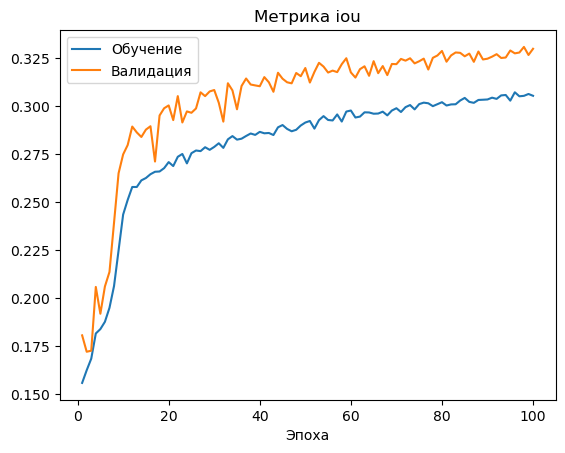

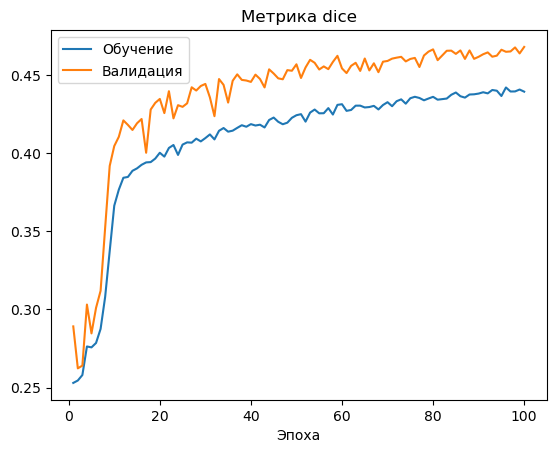

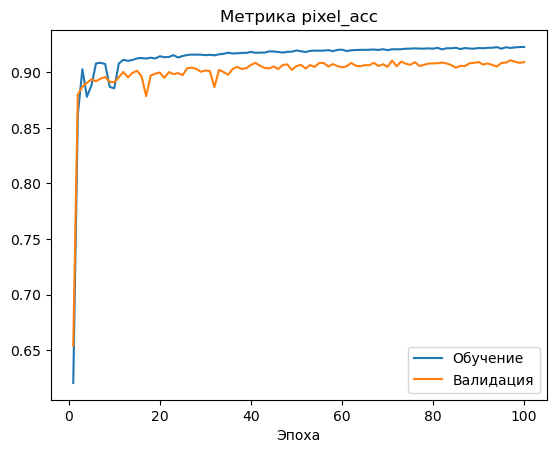

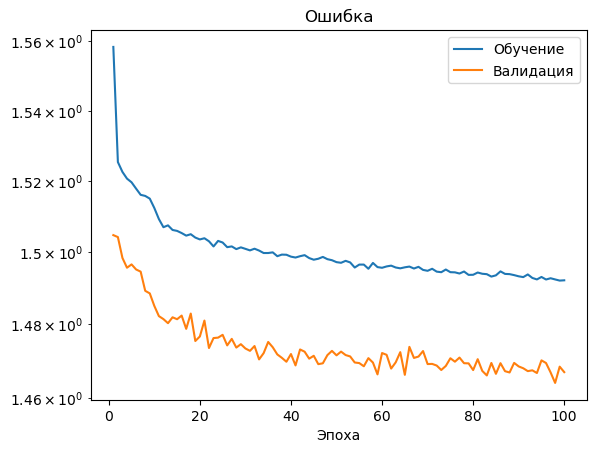

In [78]:
visualize_metrics(results_uresnet_frozen)